<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-csn2506/blob/main/week3/Chapter_2_%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3주차 기본과제
# - DistilBERT로 뉴스 기사 분류 모델 학습하기

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# AG_News dataset 준비
- Huggingface dataset의 `fancyzhx/ag_news`를 load합니다.
- `collate_fn` 함수에 다음 수정사항들을 반영하면 됩니다.
    - Truncation과 관련된 부분들을 지웁니다.

In [ ]:
ds = load_dataset("fancyzhx/ag_news")


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, max_length=max_len).input_ids) #Truncation과 관련된 부분들을 지움
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [ ]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li


#  Classifier output, loss function, accuracy function 변경
  - 뉴스 기사 분류 문제는 binary classification이 아닌 일반적인 classification 문제입니다. MNIST 과제에서 했던 것 처럼 `nn.CrossEntropyLoss` 를 추가하고 `TextClassifier`의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정하시면 됩니다.
  - 그리고 정확도를 재는 `accuracy` 함수도 classification에 맞춰 수정하시면 됩니다.

In [ ]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 4)

  def forward(self, x):
    x = self.encoder(x)['last_hidden_state']
    x = self.classifier(x[:, 0])

    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

- 정확도를 재는 accuracy 함수도 classification에 맞춰 수정하시면 됩니다

In [ ]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1) # argmax를 사용하여 예측 클래스 계산


    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch   0 | Train Loss: 891.3352906852961
=========> Train acc: 0.877 | Test acc: 0.876
Epoch   1 | Train Loss: 700.13647608459
=========> Train acc: 0.878 | Test acc: 0.876
Epoch   2 | Train Loss: 673.8537319153547
=========> Train acc: 0.889 | Test acc: 0.885
Epoch   3 | Train Loss: 659.9635524228215
=========> Train acc: 0.888 | Test acc: 0.884
Epoch   4 | Train Loss: 651.0681349113584
=========> Train acc: 0.886 | Test acc: 0.883
Epoch   5 | Train Loss: 647.0347943603992
=========> Train acc: 0.885 | Test acc: 0.883
Epoch   6 | Train Loss: 643.6611676961184
=========> Train acc: 0.883 | Test acc: 0.880
Epoch   7 | Train Loss: 639.2342626452446
=========> Train acc: 0.889 | Test acc: 0.887
Epoch   8 | Train Loss: 636.0633735656738
=========> Train acc: 0.887 | Test acc: 0.884
Epoch   9 | Train Loss: 635.5072937905788
=========> Train acc: 0.895 | Test acc: 0.892


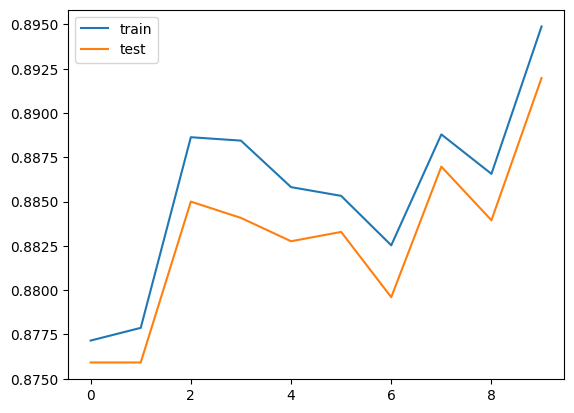

In [ ]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss() # nn.CrossEntropyLoss()로 변경

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

train_accs=[]
test_accs=[]


for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")


plot_acc(train_accs,test_accs)

Loss가 잘 떨어지고, 이전에 우리가 구현한 Transformer보다 더 빨리 수렴하는 것을 알 수 있습니다.